In [36]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import random
import tqdm

# Mini-project 1: Dealing with sparse rewards in the Mountain Car environment

In [6]:
environment = gym.make('MountainCar-v0', render_mode = "rgb_array")

## 2 First steps

In [8]:
class RandomAgent():
    def __init__(self, initial_state):
        self.state = initial_state

    def observe(self, state, action, next_state, reward):
        None
    def select_action(self, state):
        return environment.action_space.sample()
    def update(self):
        None

def run_episode(agent, render=False, video_path="video.mp4"):

    state, _ = environment.reset()
    agent = agent(state)
    done = False
    
    episode_reward = 0
    duration = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        
        episode_reward += reward
        duration += 1
        
        state = next_state
        done = terminated or truncated
    if render:
        out.release()
    return episode_reward, duration

In [9]:
list_total_rewards, list_durations = ([], [])

for episode in range(100):
    if (episode==1): kwargs = dict(render=True)
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode(RandomAgent, **kwargs)
    list_total_rewards.append(total_reward)
    list_durations.append(duration)

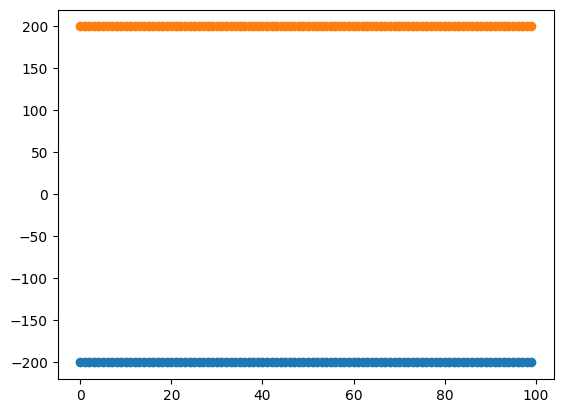

In [10]:
plt.scatter(np.arange(100), list_total_rewards)
plt.scatter(np.arange(100), list_durations)
plt.show()

## 3 DQN


In [11]:
class ReplayBuffer:    
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.num_samples = 0
        self.buffer = torch.zeros((self.capacity, 6))
        
    def add_observation(self, observation):
        #observation = (state_position, state_speed, action, reward, next_state_position, next_state_speed)
        index = self.num_samples % self.capacity

        self.buffer[index] = observation
        self.num_samples += 1

    def sample_batch(self,batch_size=64):
        record_range = min(self.num_samples, self.capacity)
        indices = torch.randint(0,record_range,size=(batch_size,))
        return self.buffer[indices]

In [41]:
class Q(torch.nn.Module):
    def __init__(self):
        super(Q, self).__init__()
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
        )

    def forward(self,state):
        Q_values = self.MLP(state)
        return Q_values

class DQN_Agent():
    
    def __init__(self, epsilon = 0.5, batch_size=64):
        self.Q = Q()
        self.discount_factor = 0.99
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer()

    def observe(self, state, action, reward, next_state):
        self.replay_buffer.add_observation(
            torch.tensor([state[0], state[1], action, reward, next_state[0], next_state[1]], dtype=torch.float32)
            )

    def select_action(self, state):
       
        if random.random() > self.epsilon:
            q_values = self.Q(torch.tensor(state, dtype=torch.float32)).numpy()
            max_q_value = np.max(q_values)
            max_actions = np.where(q_values == max_q_value)[0]
            
            return np.random.choice(max_actions)
        else:
            return environment.action_space.sample()
    
    def update(self):
        #batch.shape = (B, (S_P, S_S, A, R, S_P', S_S'))
        batch = self.replay_buffer.sample_batch(self.batch_size)
        self.optimizer.zero_grad()

        batch_next_state_Q_values = self.Q(batch[:, 4:]).clone().detach() # shape = (B, 3) 3 is action space
        batch_max_next_state_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        

        loss = 0.5 * torch.mean((batch[:, 3] + self.discount_factor*batch_max_next_state_Q_value 
                      - self.Q(batch[:, :2])[:, batch[:, 2].int()])**2)
        
        loss.backward()
        self.optimizer.step()
        return loss.item()
    

def run_episode_DQN(agent, render=False, video_path="video.mp4"):

    state, _ = environment.reset()
    done = False
    
    episode_reward = 0
    duration = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        agent.observe(state, action, reward, next_state)
        q_network_loss = agent.update()
        #print(q_network_loss)
        
        
        episode_reward += reward
        duration += 1
        state = next_state
        done = terminated or truncated
    if render:
        out.release()
    return episode_reward, duration

#run_episode_DQN()

In [49]:
agent = DQN_Agent()
list_total_rewards, list_durations = ([], [])

for episode in tqdm.tqdm(range(301)):
    if (episode==300): kwargs = dict(render=True, video_path="video_dqn.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode_DQN(agent=agent, **kwargs)
    list_total_rewards.append(total_reward)
    list_durations.append(duration)

100%|██████████| 301/301 [00:27<00:00, 10.81it/s]


In [44]:
np.unique(list_total_rewards)

array([-200.])

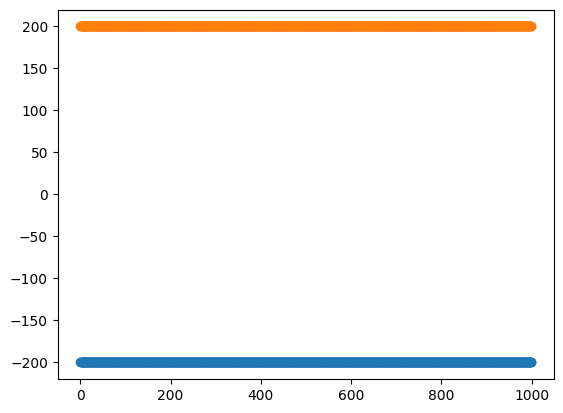

In [43]:
plt.scatter(np.arange(1000), list_total_rewards)
plt.scatter(np.arange(1000), list_durations)
plt.show()